In [3]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.model.models import DBModel

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_interpolation, plot_decision_boundary


In [2]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 16),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 33),
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [5]:
# Hyperparameters
epochs = 100
batch_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 42

torch.manual_seed(random_seed)

# Model
autoencoder = Autoencoder()
model = DBModel()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../models/autoencoders/experiment6"
model_path = "{}/model_final.pth".format(path)

In [22]:
autoencoder.train()
for i in tqdm(range(epochs)):
    for (parameters_batch, angles_batch) in dataloader:
        parameters_batch = parameters_batch.to(device)

        output = autoencoder(parameters_batch)
        loss = loss_fn(output, parameters_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {i+1}, Loss: {loss.item()}')
    if(i % 5 == 0):
        torch.save(autoencoder.state_dict(), f"{path}/checkpoint_{i}.pth")
    
torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.3930469751358032
Epoch: 2, Loss: 1.1506264209747314
Epoch: 3, Loss: 1.006199598312378
Epoch: 4, Loss: 0.9932790398597717
Epoch: 5, Loss: 0.7716034054756165
Epoch: 6, Loss: 0.767005980014801
Epoch: 7, Loss: 0.7213090658187866
Epoch: 8, Loss: 0.7789667844772339
Epoch: 9, Loss: 0.7058308124542236
Epoch: 10, Loss: 0.6744136214256287
Epoch: 11, Loss: 0.6793481707572937
Epoch: 12, Loss: 0.6341355443000793
Epoch: 13, Loss: 0.6702004671096802
Epoch: 14, Loss: 0.5343322157859802
Epoch: 15, Loss: 0.5870526432991028
Epoch: 16, Loss: 0.5175780653953552
Epoch: 17, Loss: 0.49434804916381836
Epoch: 18, Loss: 0.5180390477180481
Epoch: 19, Loss: 0.5178055167198181
Epoch: 20, Loss: 0.5437962412834167
Epoch: 21, Loss: 0.4667842388153076
Epoch: 22, Loss: 0.4539766013622284
Epoch: 23, Loss: 0.5467696785926819
Epoch: 24, Loss: 0.4359571933746338
Epoch: 25, Loss: 0.477660208940506
Epoch: 26, Loss: 0.4966064393520355
Epoch: 27, Loss: 0.44648659229278564
Epoch: 28, Loss: 0.38222768902778625
E

(80000, 16)
(80000, 3)


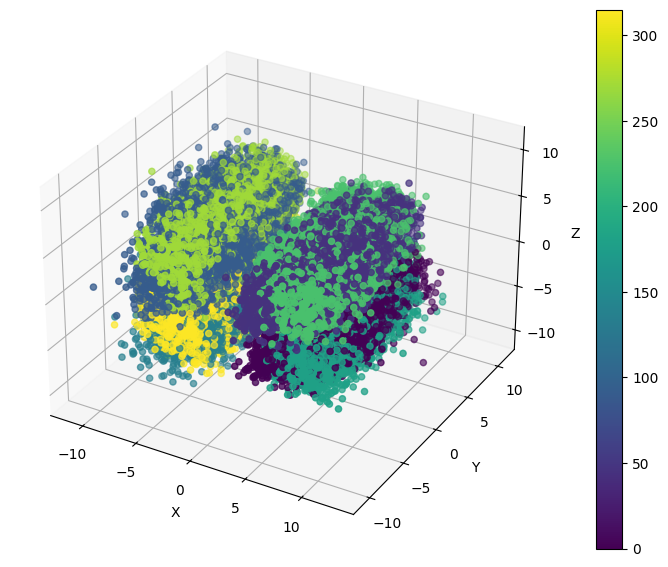

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

latent = autoencoder.encoder(torch.tensor(weights).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

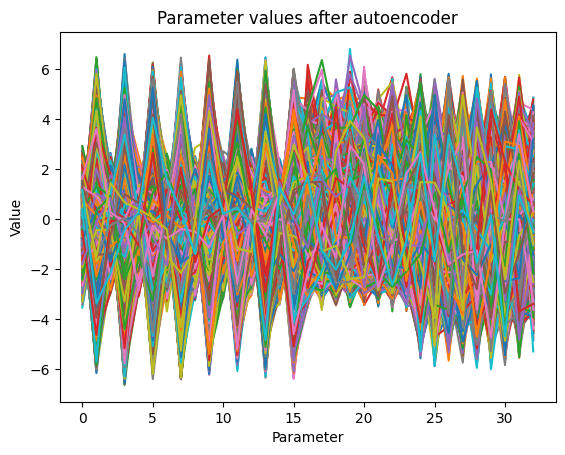

In [24]:
from matplotlib import pyplot as plt
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(f"{path}/autoencoder_final.pth"))
autoencoder.eval()

reconstruction = []
for i in range(40000, 50000):
    parameters = dataset[i][0].unsqueeze(0)
    r = autoencoder(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values after autoencoder")
plt.show()

## Accuracy distribution

  0%|          | 0/80000 [00:00<?, ?it/s]

Mean trained accuracy: 99.87490625000002
Mean reconstructed accuracy: 97.91859


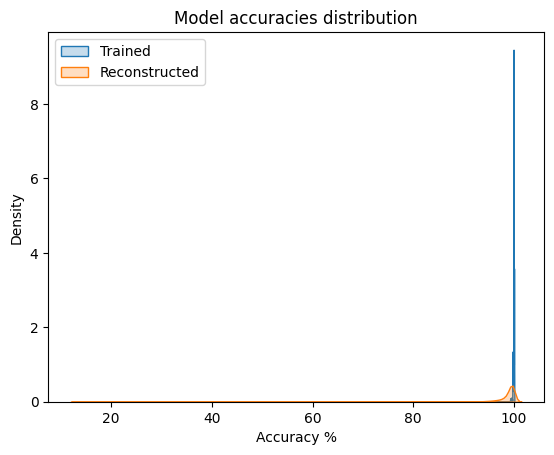

In [8]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    accuracy = get_accuracy(parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    accuracy = get_accuracy(reconstructed, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()


## Interpolation

  0%|          | 0/8 [00:00<?, ?it/s]

Mean interpolation accuracy: 71.15919375000001


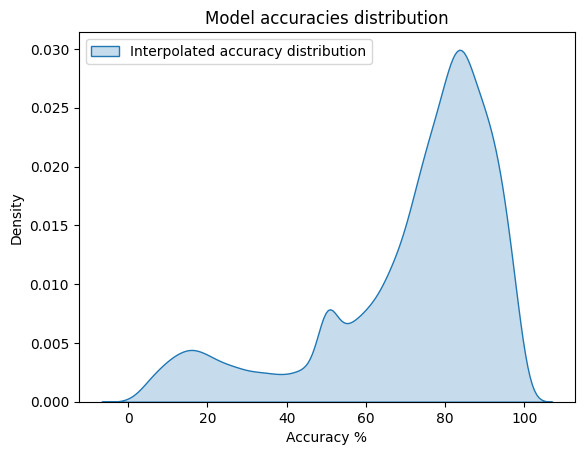

In [11]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(f"{path}/autoencoder_final.pth"))
model = DBModel(autoencoder, True).eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []

for i in tqdm(range(-1, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)
        w = (1-alpha)*weight_1 + alpha*weight_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = torch.tensor(w).float().unsqueeze(0)
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)
        accuracy = get_accuracy(tester, X_rotated, y, w)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()

In [9]:
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0
index_1 = 0
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function src.visualization.visualize.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>